# Preamble

You can safely skip reading this section at first reading. Here we:
 - import the required python modules 
 - set few parameters for the solvers to use later
 - define output directory and files

In [1]:
# Setup system environment and define utility functions and variables
try : 
    from google.colab import files
except:
    pass
try:
    from dolfin import *;  from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *    
!dolfin-version
import matplotlib.pyplot as plt
import numpy as np
import sys, os, sympy, shutil, math
%matplotlib inline
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 2
parameters["form_compiler"]["representation"]="uflacs"
parameters["use_petsc_signal_handler"] = True
info(parameters,True)

2018.2.0.dev0


# Mesh 

We define here the mesh and the indicators for the boundary conditions

0.021209256675352638

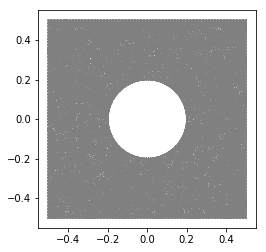

In [2]:
R = 0.2
H = 1.
L = 1.
rect = Rectangle(Point(-L/2,-H/2),Point(L/2,H/2))
circ = Circle(Point(0.001,0),R)
mesh = generate_mesh(rect-circ,60)
plot(mesh)
top = CompiledSubDomain("near(x[1], %f/2., 1.e-4)"%H)
hole = CompiledSubDomain("near(pow(x[0],2)+pow(x[1],2), pow(%f,2), 1.e-3)"%R )
boundaries = MeshFunction("size_t", mesh,1)
boundaries.set_all(0)
top.mark(boundaries, 1) 
hole.mark(boundaries, 2) 
ds = Measure("ds",subdomain_data=boundaries) 

ndim = mesh.topology().dim() # get number of space dimensions
zero_v = Constant((0.,)*ndim) # a ndim-dimensional zero vector
mesh.hmax()

# Constitutive functions

We define here the constitutive functions and the related parameters. 
These functions will be used to define the energy

In [3]:
E, nu = Constant(100.0), Constant(0.3)
Gc = Constant(1.0)
ell = Constant(0.05)

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha):
    """Stiffness modulation as a function of the damage """
    k_ell = Constant(1.e-6) # residual stiffness
    return (1-alpha)**2+k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return sym(grad(u))

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E/(2.0*(1.0 + nu))
    lmbda = E*nu/(1.0 - nu**2)
    return 2.0*mu*(eps(u)) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return (a(alpha))*sigma_0(u)

z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)
c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)
tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp*Gc*E/(c_w*ell))
print("sigma_c = %2.3f"%sigma_c)
eps_c = float(sigma_c/E)
print("eps_c = %2.3f"%eps_c)

c_w =  8/3
c_1/w =  2
sigma_c = 27.386
eps_c = 0.274


## Energy functional and its derivatives

In [4]:
# Create function space for 2D elasticity + Damage
V_u = VectorFunctionSpace(mesh, "P", 1)
V_alpha = FunctionSpace(mesh, "P", 1)

# Define the function, test and trial fields
u, du, v = Function(V_u), TrialFunction(V_u), TestFunction(V_u)
alpha, dalpha, beta = Function(V_alpha), TrialFunction(V_alpha), TestFunction(V_alpha)

elastic_energy = 0.5*inner(sigma(u,alpha), eps(u))*dx
dissipated_energy = Gc/float(c_w)*(w(alpha)/ell+ ell*dot(grad(alpha), grad(alpha)))*dx
total_energy = elastic_energy + dissipated_energy 

# Weak form of elasticity problem
E_u = derivative(total_energy,u,v)
E_alpha = derivative(total_energy,alpha,beta)
E_alpha_alpha = derivative(E_alpha,alpha,dalpha)

Boundary conditions

In [5]:
# Dirichlet boundary condition for a traction test boundary
uT = Expression("t",t = 0.,degree=0)
bcu_0 = DirichletBC(V_u.sub(1), uT, boundaries, 1)
bcu_1 = DirichletBC(V_u, (0.0,0.0), boundaries, 2)
bc_u = [bcu_0, bcu_1]
bcalpha_0 = DirichletBC(V_alpha, 0.0, boundaries, 1)
bcalpha_1 = DirichletBC(V_alpha, 0.0, boundaries, 2)
bc_alpha = [bcalpha_0, bcalpha_1]

## Solvers

### Displacement problem

In [6]:
import ufl
E_du = ufl.replace(E_u,{u:du})
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "mumps"})

### Damage problem with bound constraints

In [7]:
class DamageProblem(OptimisationProblem):

    def f(self, x):
        """Function to be minimised"""
        alpha.vector()[:] = x
        return assemble(total_energy)

    def F(self, b, x):
        """Gradient (first derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha, b)

    def J(self, A, x):
        """Hessian (second derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha_alpha, A)
        
#PETScOptions.set("help")
solver_alpha_tao = PETScTAOSolver()
#solver_alpha_tao.parameters.update({"monitor_convergence": True})
PETScOptions.set("tao_type","tron")
#PETScOptions.set("pc_type","ilu")
#PETScOptions.set("ksp_type","nash")
PETScOptions.set("tao_monitor")
lb = interpolate(Constant("0."), V_alpha) # lower bound, initialize to 0
ub = interpolate(Constant("1."), V_alpha) # upper bound, set to 1
for bc in bc_alpha:
    bc.apply(lb.vector())
    bc.apply(ub.vector())

### Alternate minimization

In [8]:
def alternate_minimization(u,alpha,tol=1.e-5,maxiter=100,alpha_0=interpolate(Constant("0.0"), V_alpha)):
    # initialization
    iter = 1; err_alpha = 1
    alpha_error = Function(V_alpha)
    # iteration loop
    while err_alpha>tol and iter<maxiter:
        # solve elastic problem
        solver_u.solve()
        # solve damage problem
        #solver_alpha.solve()
        solver_alpha_tao.solve(DamageProblem(), alpha.vector(), lb.vector(), ub.vector())# test error
        alpha_error.vector()[:] = alpha.vector() - alpha_0.vector()
        err_alpha = norm(alpha_error.vector(), "linf")
        # monitor the results
        if MPI.comm_world.rank == 0:
            print("Iteration:  %2d, Error: %2.8g, alpha_max: %.8g" %(iter, err_alpha, alpha.vector().max()))
        # update iteration
        alpha_0.assign(alpha)
        iter=iter+1
    return (err_alpha, iter)

## Time-step post-processing

In [9]:
savedir = "results-inclusion/"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd") 

def postprocessing():
    plt.figure(i_t)
    plt.colorbar(plot(alpha, range_min=0., range_max=1., title = "Damage at loading %.4f"%(t*load0)))
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    # Calculate the energies
    elastic_energy_value = assemble(elastic_energy)
    surface_energy_value = assemble(dissipated_energy)
    if MPI.comm_world.rank == 0:
        print("\nEnd of timestep %d with load multiplier %g"%(i_t, t))
        print("\nElastic and surface energies: (%g,%g)"%(elastic_energy_value,surface_energy_value))
        print("-----------------------------------------")
    energies[i_t] = np.array([t,elastic_energy_value,surface_energy_value,elastic_energy_value+surface_energy_value])
    # Calculate the axial force resultant
    forces[i_t] = np.array([t,assemble(sigma(u,alpha)[1,1]*ds(0))])
    # Dump solution to file
    file_alpha << (alpha,t)
    file_u << (u,t)
    # Save some global quantities as a function of the time
    np.savetxt(savedir+'/energies.txt', energies)
    np.savetxt(savedir+'/forces.txt', forces)
    np.savetxt(savedir+'/iterations.txt', iterations)

## Solving at each time instant and looping in time

Iteration:   1, Error:  0, alpha_max: 0

End of timestep 0 with load multiplier 0

Elastic and surface energies: (0,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 1 with load multiplier 0.00408163

Elastic and surface energies: (0.00170371,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 2 with load multiplier 0.00816327

Elastic and surface energies: (0.00681484,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 3 with load multiplier 0.0122449

Elastic and surface energies: (0.0153334,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 4 with load multiplier 0.0163265

Elastic and surface energies: (0.0272594,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 5 with load multiplier 0.0204082

Elastic and surface energies: (0.042

/Users/maurini/fenics/2018.1.0/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



End of timestep 20 with load multiplier 0.0816327

Elastic and surface energies: (0.678392,0.00301009)
-----------------------------------------
Iteration:   1, Error: 0.042619927, alpha_max: 0.077443145
Iteration:   2, Error: 0.02508738, alpha_max: 0.10088745
Iteration:   3, Error: 0.016493546, alpha_max: 0.11699652
Iteration:   4, Error: 0.011053263, alpha_max: 0.1280273
Iteration:   5, Error: 0.0074959474, alpha_max: 0.13551524
Iteration:   6, Error: 0.0051278825, alpha_max: 0.14064312
Iteration:   7, Error: 0.0035316002, alpha_max: 0.14417472
Iteration:   8, Error: 0.002441782, alpha_max: 0.1466165
Iteration:   9, Error: 0.0016943727, alpha_max: 0.14831087
Iteration:  10, Error: 0.001179352, alpha_max: 0.14949023
Iteration:  11, Error: 0.00082147936, alpha_max: 0.15031171
Iteration:  12, Error: 0.00057200941, alpha_max: 0.15088372
Iteration:  13, Error: 0.00039860851, alpha_max: 0.15128232
Iteration:  14, Error: 0.00027791352, alpha_max: 0.15156024
Iteration:  15, Error: 0.0001938

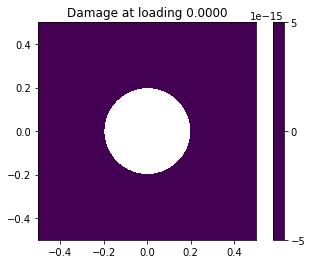

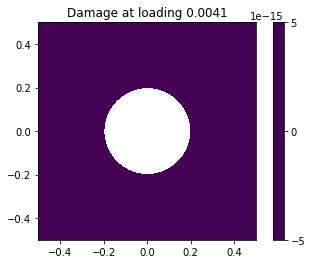

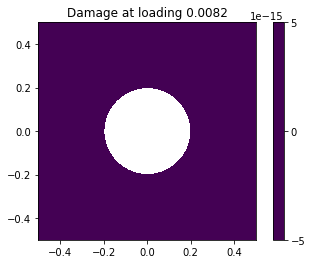

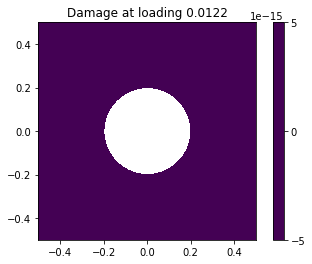

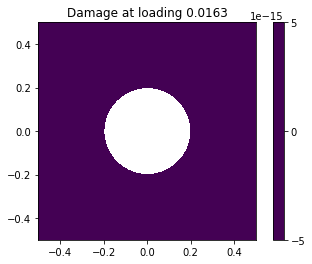

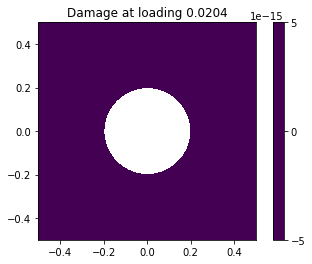

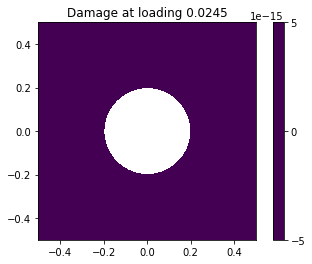

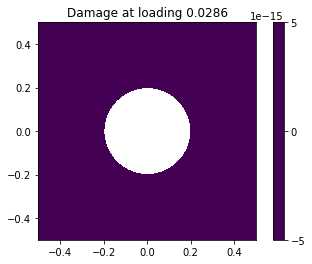

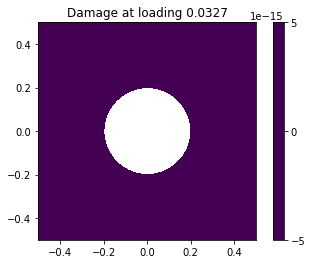

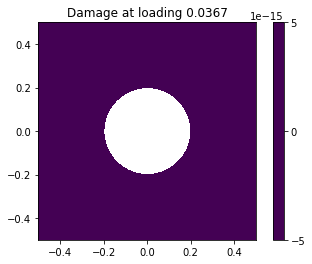

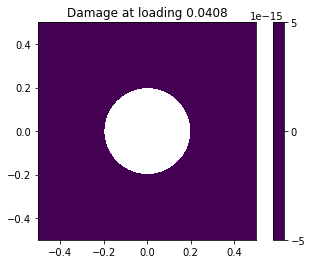

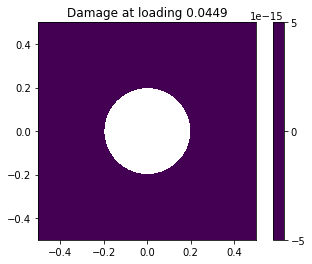

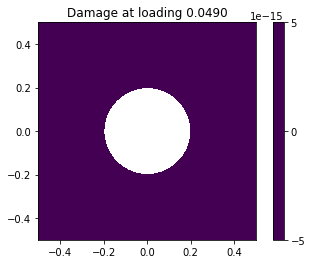

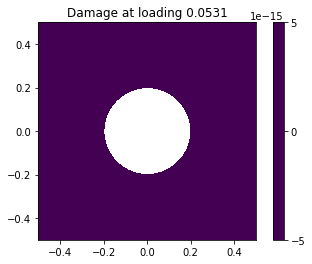

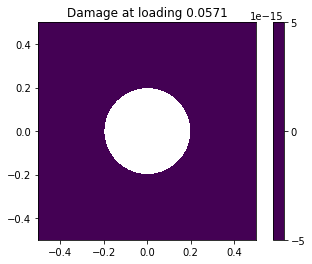

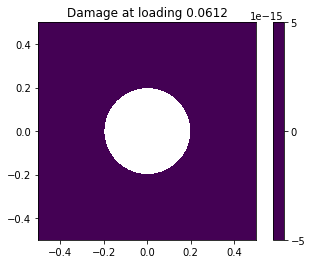

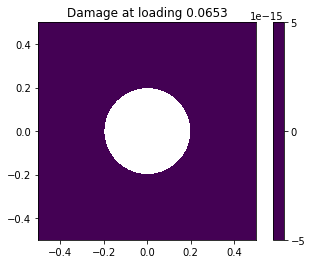

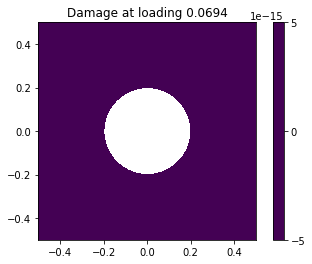

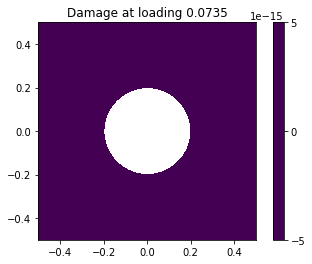

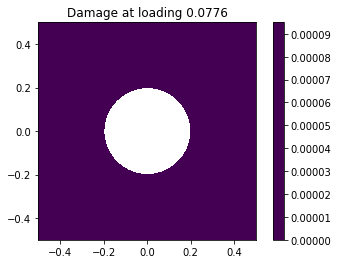

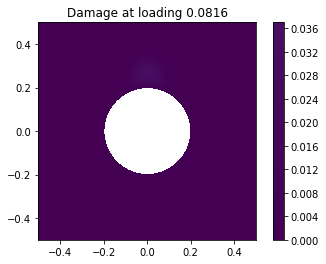

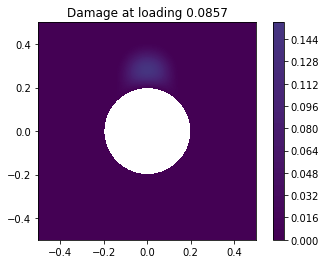

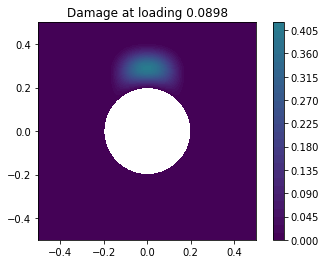

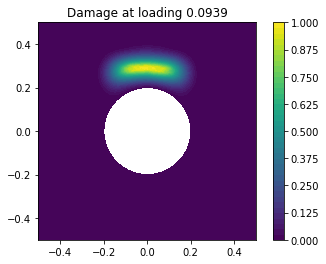

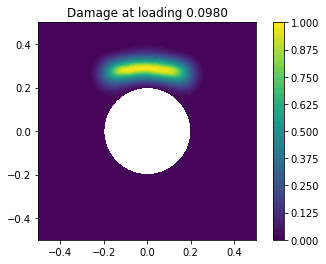

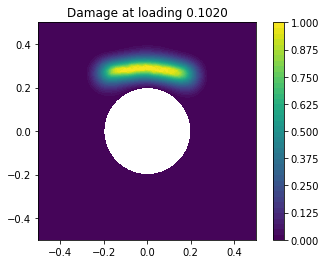

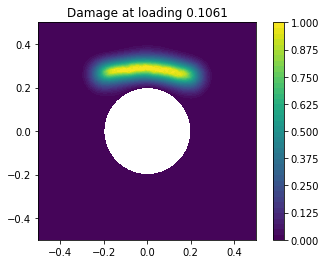

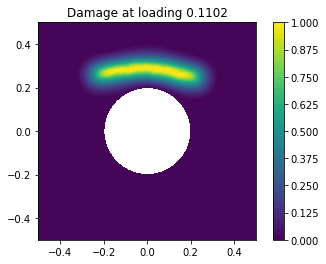

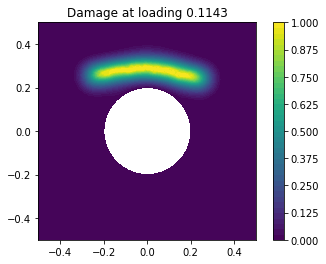

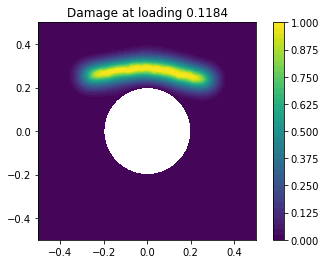

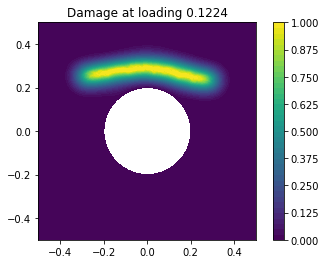

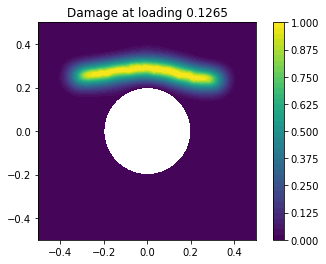

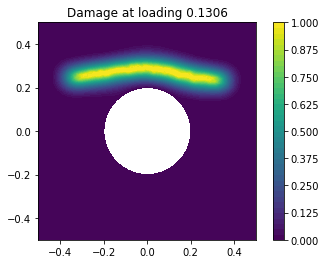

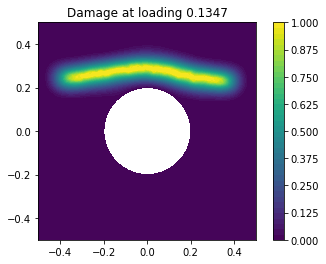

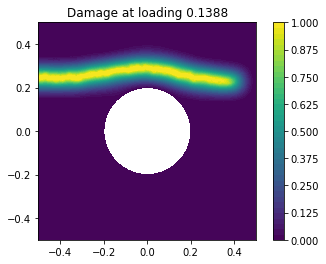

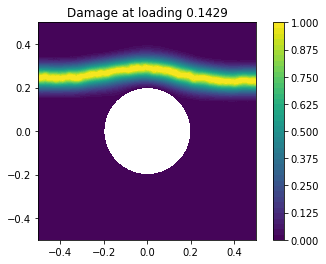

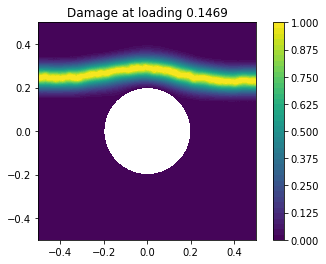

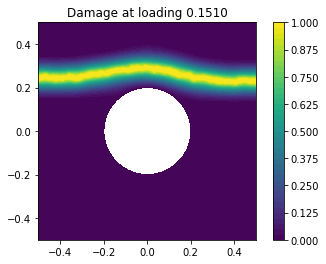

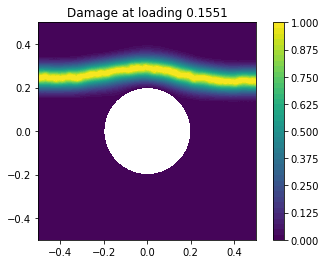

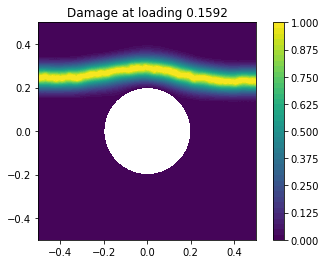

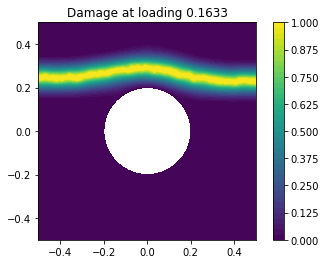

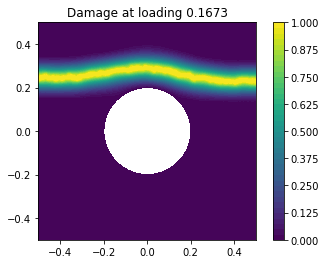

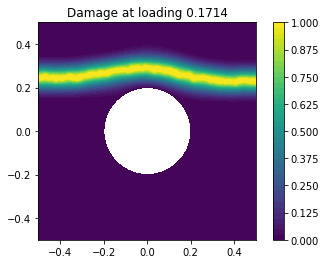

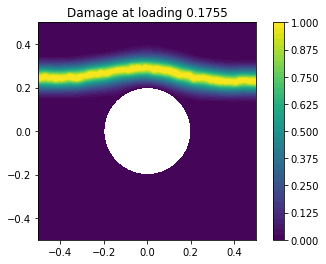

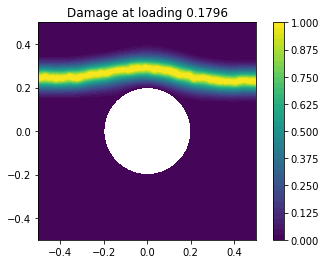

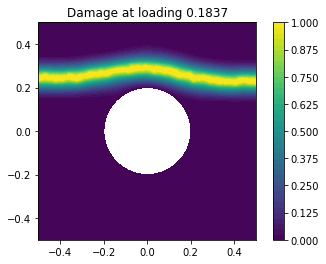

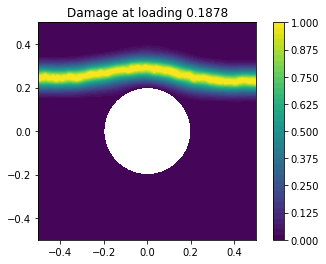

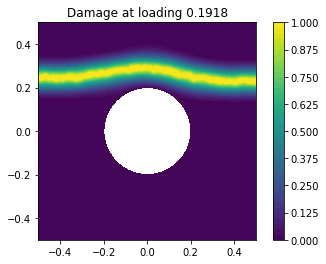

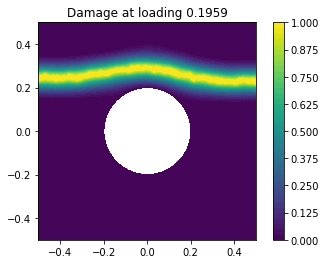

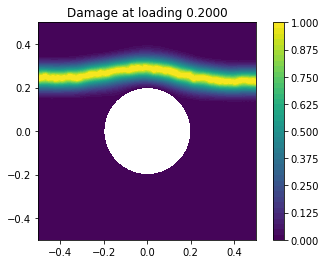

In [10]:
load0 = 1. # reference value for the loading (imposed displacement)
load_multipliers = load0*np.linspace(0,0.2,50)
#  loading and initialization of vectors to store time datas
energies = np.zeros((len(load_multipliers),4))
iterations = np.zeros((len(load_multipliers),2))
forces = np.zeros((len(load_multipliers),2))

lb.interpolate(Constant(0.))
for (i_t, t) in enumerate(load_multipliers):
    uT.t = t*load0
    # solve alternate minimization
    alternate_minimization(u,alpha,maxiter=30)
    # updating the lower bound to account for the irreversibility
    lb.vector()[:] = alpha.vector()
    postprocessing()

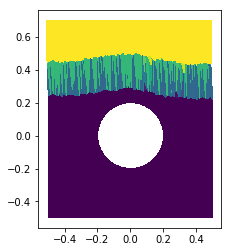

In [16]:
plot(u,mode='displacement')

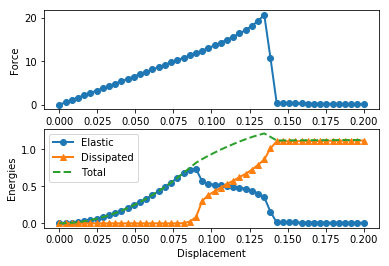

In [17]:
# Plot energy and stresses
import matplotlib.pyplot as plt

def plot_stress():
    plt.plot(forces[:,0], forces[:,1], '-o', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')

def plot_energy():
    p1, = plt.plot(energies[:,0], energies[:,1],'-o',linewidth=2)
    p2, = plt.plot(energies[:,0], energies[:,2],'-^',linewidth=2)
    p3, = plt.plot(energies[:,0], energies[:,3],'--',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')

def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig(savedir+'/energies_force.png')
    plt.show()

plot_energy_stress()

In [24]:
plt.close()